In [114]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, precision_score,recall_score, f1_score
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
bicycle_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle'
motorcycle_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/motorcycle'
bus_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bus'
car_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/car'
truck_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/single_unit_truck'

In [5]:
import plotly.express as px

class_names = ['bicycle', 'bus','car','motorcycle','truck'] 
bicycle = len(os.listdir(bicycle_file_path))
bus = len(os.listdir(bus_file_path))
car = len(os.listdir(car_file_path))
motorcycle = len(os.listdir(motorcycle_file_path))
truck = len(os.listdir(truck_file_path))

n_images = [bicycle, bus, car,motorcycle,truck]

fig = px.bar(x=class_names, y=n_images, color=class_names, labels={'x': 'Class', 'y': 'Number of Images'}, title='Count of the Images')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [6]:
from sklearn.utils import resample

# Mapping labels to numerical values
label_mapping = {'bicycle': 0, 'motorcycle': 1, 'bus': 2, 'car': 3, 'truck': 4}

# Function to down-sample a class
def downsample_class(class_path, target_size, label):
    files = os.listdir(class_path)
    downsampled_files = resample(files, replace=False, n_samples=target_size, random_state=42)
    labeled_files = [(os.path.join(class_path, file), label_mapping[label]) for file in downsampled_files]
    return labeled_files

# Determine the minimum number of samples across all classes
min_samples = min(len(os.listdir(bicycle_file_path)), len(os.listdir(motorcycle_file_path)), len(os.listdir(bus_file_path)), len(os.listdir(car_file_path)), len(os.listdir(truck_file_path)))

# Store down-sampled files and labels in data[] list
data = []

# Down-sample each class and append labeled data to the data[] list
data.extend(downsample_class(bicycle_file_path, min_samples, 'bicycle'))
data.extend(downsample_class(motorcycle_file_path, min_samples, 'motorcycle'))
data.extend(downsample_class(bus_file_path, min_samples, 'bus'))
data.extend(downsample_class(car_file_path, min_samples, 'car'))
data.extend(downsample_class(truck_file_path, min_samples, 'truck'))

# Display the first few entries in data[]
print(data[:5])

[('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00275397.jpg', 0), ('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00166176.jpg', 0), ('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00369905.jpg', 0), ('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00210695.jpg', 0), ('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00399755.jpg', 0)]


In [7]:
len(data)

9910

In [8]:
random.shuffle(data)

In [9]:
data[0]

('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00271242.jpg',
 0)

In [10]:
count = {0:0,1:0,2:0,3:0,4:0}
for d in data:
    count[d[1]]+=1

In [11]:
class_names = ['bicycle','motorcycle','bus','car','truck'] 
fig = px.bar(x=class_names, y=count, color=class_names, labels={'x': 'Class', 'y': 'Number of Images'}, title='Count of the Images')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [12]:
from PIL import Image
import numpy as np

# Function to resize and normalize images
def preprocess_images(data, target_size=(224, 224), normalization=True):
    processed_data = []
    
    for file_path, label in data:
        # Open the image file
        image = Image.open(file_path)
        
        # Resize the image
        image = image.resize(target_size)
        
        # Convert the image to a numpy array
        image_array = np.array(image)
        
        # Normalize the image (if normalization is enabled)
        if normalization:
            image_array = image_array / 255.0  # Normalize pixel values to the range [0, 1]
        
        # Append the processed data as a tuple (image_array, label)
        processed_data.append((image_array, label))
    
    return processed_data

df = preprocess_images(data, target_size=(224, 224), normalization=True)

In [100]:
train_data,test_data  = train_test_split(df, train_size=0.8, random_state=42)

In [101]:
test_data,valid_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [102]:
len(test_data)

991

In [103]:
# Assuming you have the processed data in resized_normalized_data
# where each element is a tuple (image_array, label)
# Custom dataset class
class CustomDataset:
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image_array, label = self.data[index]
        # Convert image_array to PyTorch tensor
        image_tensor = torch.tensor(image_array, dtype=torch.float32).permute(2, 0, 1)
        return image_tensor, torch.tensor(label, dtype=torch.long)
# Create DataLoader for training and testing sets
batch_size = 64
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)
validation_dataset = CustomDataset(valid_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [104]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [106]:
# Instantiate the model
model = SimpleCNN().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [107]:
num_epochs = 10
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')
    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'validation Accuracy: {accuracy_val:.2f}% , validation loss : {valid_loss:.4f}')

Epoch 1/10, Loss: 1.1185, Accuracy: 55.83%
validation Accuracy: 69.93% , validation loss : 0.8103
Epoch 2/10, Loss: 0.7344, Accuracy: 71.87%
validation Accuracy: 76.49% , validation loss : 0.6441
Epoch 3/10, Loss: 0.5972, Accuracy: 78.23%
validation Accuracy: 79.01% , validation loss : 0.5819
Epoch 4/10, Loss: 0.5140, Accuracy: 81.65%
validation Accuracy: 79.92% , validation loss : 0.5454
Epoch 5/10, Loss: 0.4474, Accuracy: 84.32%
validation Accuracy: 81.74% , validation loss : 0.5211
Epoch 6/10, Loss: 0.3813, Accuracy: 86.91%
validation Accuracy: 83.05% , validation loss : 0.4687
Epoch 7/10, Loss: 0.3366, Accuracy: 88.61%
validation Accuracy: 84.26% , validation loss : 0.4431
Epoch 8/10, Loss: 0.2888, Accuracy: 89.82%
validation Accuracy: 84.46% , validation loss : 0.4353
Epoch 9/10, Loss: 0.2539, Accuracy: 91.38%
validation Accuracy: 85.37% , validation loss : 0.4000
Epoch 10/10, Loss: 0.2198, Accuracy: 92.75%
validation Accuracy: 85.67% , validation loss : 0.3981


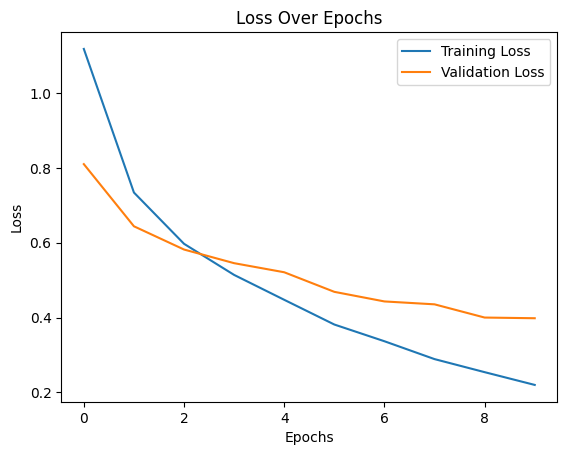

In [109]:
plt.plot(loss_graph, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

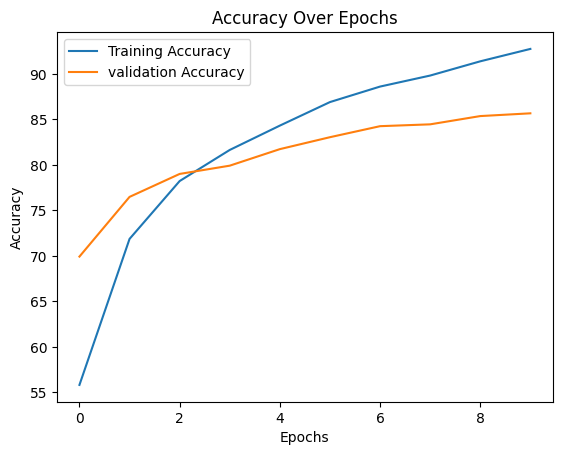

In [110]:
plt.plot(accuracy_graph, label='Training Accuracy')
plt.plot(accuracy_valid, label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [111]:
# Final evaluation on the test set
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
accuracy_test = correct_test / total_test * 100
print(f'Final Test Accuracy: {accuracy_test:.2f}%')

Final Test Accuracy: 86.07%


In [90]:
train_data,test_data  = train_test_split(df, train_size=0.8, random_state=42)

In [91]:
test_data,validation_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [92]:
# Assuming you have the processed data in resized_normalized_data
# where each element is a tuple (image_array, label)
# Custom dataset class
class CustomDataset:
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image_array, label = self.data[index]
        # Convert image_array to PyTorch tensor
        image_tensor = torch.tensor(image_array, dtype=torch.float32).permute(2, 0, 1)
        return image_tensor, torch.tensor(label, dtype=torch.long)
# Create DataLoader for training and testing sets
batch_size = 128
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)
validation_dataset = CustomDataset(validation_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [93]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256,512)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.fc3(x)
        return x

In [94]:
# Instantiate the model
model = SimpleCNN().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [95]:
num_epochs = 30
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')
    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'validation Accuracy: {accuracy_val:.2f}% , validation loss : {valid_loss:.4f}')

Epoch 1/30, Loss: 1.6082, Accuracy: 20.18%
validation Accuracy: 23.21% , validation loss : 1.6046
Epoch 2/30, Loss: 1.5987, Accuracy: 26.89%
validation Accuracy: 32.69% , validation loss : 1.5849
Epoch 3/30, Loss: 1.5643, Accuracy: 32.49%
validation Accuracy: 38.65% , validation loss : 1.5257
Epoch 4/30, Loss: 1.4784, Accuracy: 39.80%
validation Accuracy: 41.07% , validation loss : 1.4055
Epoch 5/30, Loss: 1.3445, Accuracy: 46.46%
validation Accuracy: 48.54% , validation loss : 1.2632
Epoch 6/30, Loss: 1.2183, Accuracy: 51.77%
validation Accuracy: 50.66% , validation loss : 1.1704
Epoch 7/30, Loss: 1.1298, Accuracy: 54.09%
validation Accuracy: 55.30% , validation loss : 1.0840
Epoch 8/30, Loss: 1.0626, Accuracy: 56.91%
validation Accuracy: 56.81% , validation loss : 1.0335
Epoch 9/30, Loss: 1.0036, Accuracy: 59.04%
validation Accuracy: 58.83% , validation loss : 0.9850
Epoch 10/30, Loss: 0.9562, Accuracy: 61.52%
validation Accuracy: 61.35% , validation loss : 0.9300
Epoch 11/30, Loss: 

In [96]:
loss_valid

[1.604567289352417,
 1.5849323868751526,
 1.5257237702608109,
 1.405466690659523,
 1.2631688714027405,
 1.1703736335039139,
 1.084032729268074,
 1.0334546864032745,
 0.985027626156807,
 0.9300059452652931,
 0.8990902528166771,
 0.8723719641566277,
 0.8510994240641594,
 0.8311354368925095,
 0.8025635480880737,
 0.7904941141605377,
 0.7730152532458305,
 0.7721908539533615,
 0.7480060756206512,
 0.7290030717849731,
 0.7181835547089577,
 0.7233206108212471,
 0.7063874304294586,
 0.6856206133961678,
 0.693025566637516,
 0.6758727505803108,
 0.665811724960804,
 0.6561374291777611,
 0.6468946263194084,
 0.6459901928901672]

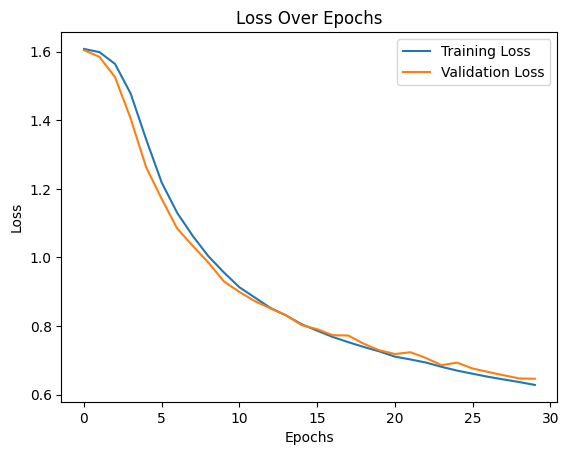

In [97]:
plt.plot(loss_graph, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

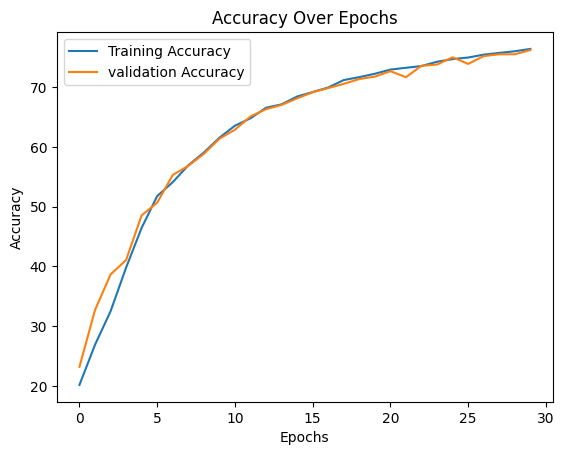

In [98]:
plt.plot(accuracy_graph, label='Training Accuracy')
plt.plot(accuracy_valid, label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

Final Test Top-1 Accuracy: 86.07%
Final Test Top-3 Accuracy: 98.69%


Text(0.5, 1.0, 'Confusion Matrix')

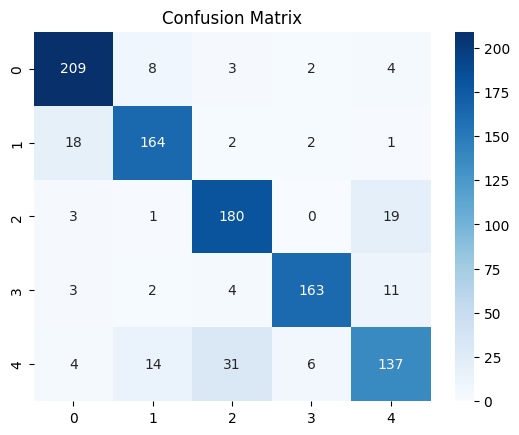

In [116]:
# Final evaluation on the test set
model.eval()
correct_top1_test = 0
correct_top3_test = 0
total_test = 0
all_labels = []
all_predictions_top = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        # Top-1 accuracy
        _, predicted_top1 = torch.max(outputs.data, 1)
        correct_top1_test += (predicted_top1 == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions_top.extend(predicted_top1.cpu().numpy())

        # Top-3 accuracy
        _, predicted_top3 = torch.topk(outputs.data, 3, dim=1)
        correct_top3_test += torch.sum(predicted_top3 == labels.view(-1, 1)).item()

        total_test += labels.size(0)

# Calculate top-1 and top-3 accuracy for the test set
top1_accuracy_test = correct_top1_test / total_test * 100
top3_accuracy_test = correct_top3_test / total_test * 100

print(f'Final Test Top-1 Accuracy: {top1_accuracy_test:.2f}%')
print(f'Final Test Top-3 Accuracy: {top3_accuracy_test:.2f}%')

conf_matrix_top1 = confusion_matrix(all_labels, all_predictions_top)
sns.heatmap(conf_matrix_top1, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")